In [1]:
import sys
sys.path.append(r"C:\Users\afeki\Desktop\code\CrossValidatedFeatureSelection\experiments")  # path contains python_file.py
from plot_utils import get_results_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
FOLDER = "C:/Users/afeki/Desktop/code/CrossValidatedFeatureSelection/experiments/gbm_classification/criteo_ctr/30FoldCV"
fi, metrics = get_results_data(FOLDER, normalize=True, one_hot=False)

df_map = { 'gain': 'Gain', 'permutation_test' : "Permutation Test", 'permutation_train' : 'Permutation Train', 'shap_test': 'Shap','shap_train': 'Shap Train'}
model_map = {'LGBM' : 'LGBM', 'CATBOOST' : 'CatBoost', 'Ours' : 'CVB', 'Vanilla_GBM' : 'Vanilla GBM', 'SKLEARN_MI' : 'SKLEARN Mean Imputing','XGBOOST_MI' : 'XGBOOST Mean Imputing'}
metrics['model'] = metrics['model'].map(model_map)
metrics.to_csv("metrics_summary.csv", index = None)

def translate_value_names(df):
    df['fi_type'] = df['fi_type'].map(df_map)
    df['model'] = df['model'].map(model_map)
    df.columns = ['Features', "Feature Importance Type", 'Value', 'exp','Model']
    
translate_value_names(fi)
fi.head(2)

,Features,Feature Importance Type,Value,exp,Model
0,C1,Gain,0.000000,0,LGBM
1,C14,Gain,0.110561,0,LGBM


In [3]:
dataset = pd.read_csv("C:/Users/afeki/Desktop/code/CrossValidatedFeatureSelection/datasets/criteo_ctr_prediction/train_30k.csv")
dataset = dataset.drop(columns=['click', 'hour', 'id', 'Unnamed: 0'])
print(dataset.shape)
l = []
for col in dataset.columns:
    l.append([col, dataset[col].dtype, dataset[col].isna().sum(),len(np.unique(dataset[col]))])  
df = pd.DataFrame(l, columns = ['feature','dtype', '# nan values','n_unique_values'])
df = df.sort_values('n_unique_values', ascending = False)
display(df)

(30000, 21)


,feature,dtype,# nan values,n_unique_values
9,device_ip,object,0,25573
8,device_id,object,0,4928
10,device_model,object,0,2154
13,C14,int64,0,1282
2,site_id,object,0,918
3,site_domain,object,0,784
5,app_id,object,0,723
16,C17,int64,0,372
19,C20,int64,0,145
6,app_domain,object,0,64


In [4]:
feature_order = df['feature'].values
include_features = [f  for f in feature_order if list(feature_order).index(f) <= list(feature_order).index('app_category')]
feature_order = [f for f in feature_order if f in include_features] + ['Other Variables']
list(feature_order)

['device_ip',
 'device_id',
 'device_model',
 'C14',
 'site_id',
 'site_domain',
 'app_id',
 'C17',
 'C20',
 'app_domain',
 'C19',
 'C21',
 'app_category',
 'Other Variables']

In [5]:
fi.loc[~fi['Features'].isin(include_features),'Features'] = 'Other Variables'
fi = fi.groupby(['Features','Feature Importance Type','exp','Model'])['Value'].sum().to_frame('Value').reset_index()
# fi = fi[fi['Features'].isin(include_features)]

In [6]:
fi

,Features,Feature Importance Type,exp,Model,Value
0,C14,Gain,0,CVB,0.000000
1,C14,Gain,0,CatBoost,0.087560
2,C14,Gain,0,LGBM,0.110561
3,C14,Gain,0,SKLEARN Mean Imputing,0.005205
4,C14,Gain,0,Vanilla GBM,0.016610
...,...,...,...,...,...
11755,site_id,Shap Train,29,CatBoost,0.205018
11756,site_id,Shap Train,29,LGBM,0.211836
11757,site_id,Shap Train,29,SKLEARN Mean Imputing,0.008555
11758,site_id,Shap Train,29,Vanilla GBM,0.000000


C:\Users\afeki\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


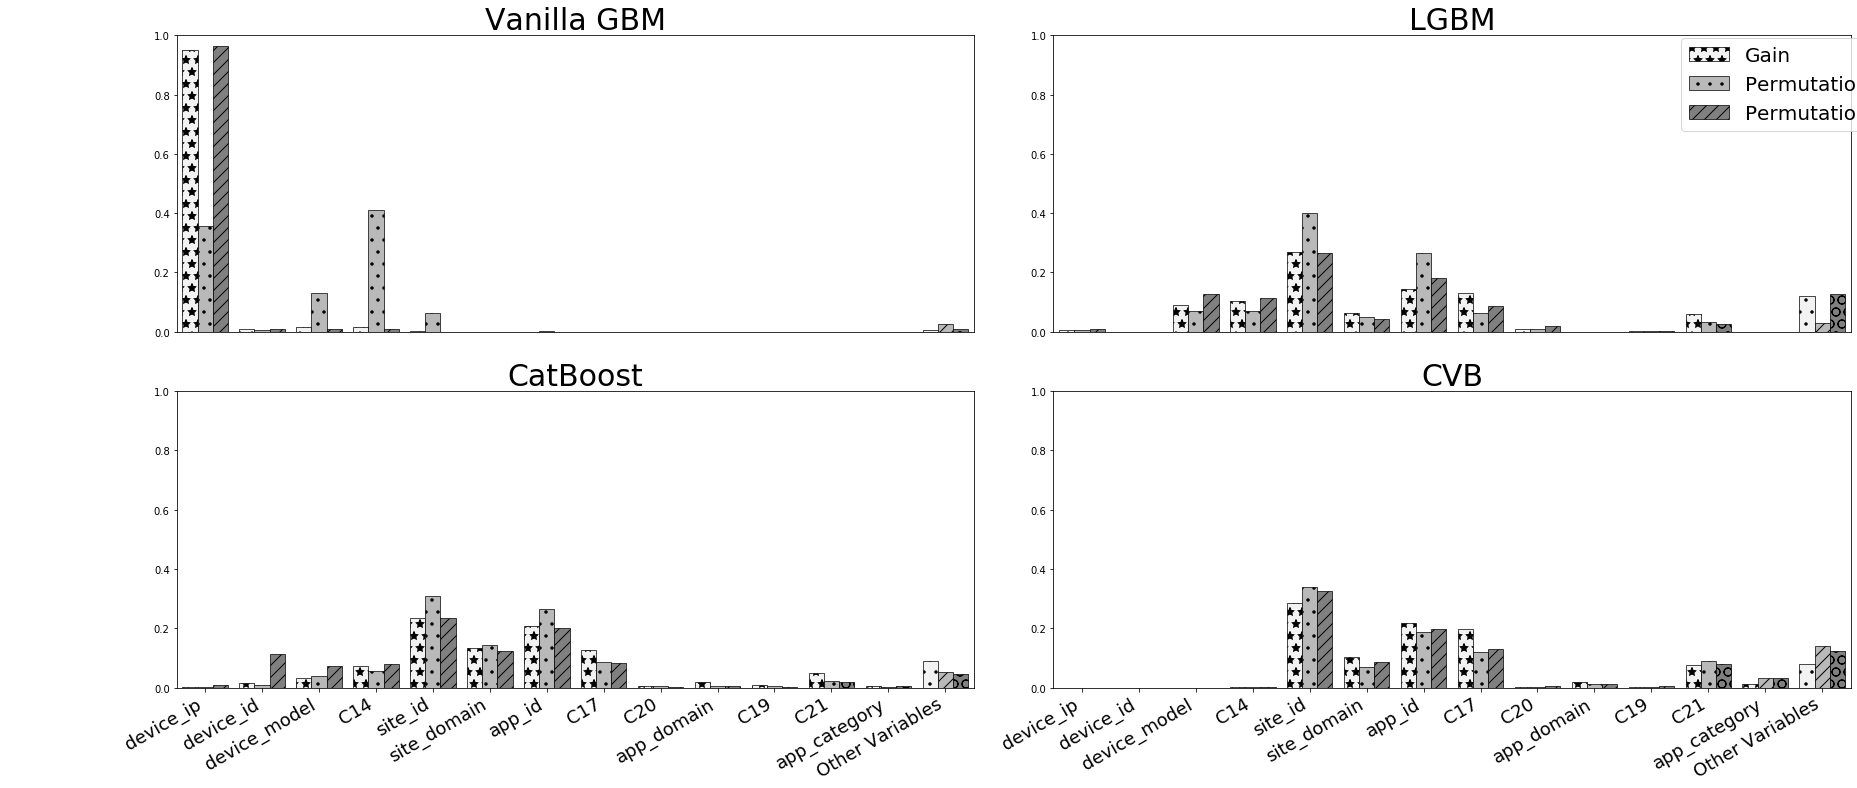

In [15]:
models = ['Vanilla GBM', 'LGBM', 'CatBoost', 'CVB']

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

def first_paper_graph(data,title):
    fig,a =  plt.subplots(2,2, figsize=(30, 12))
    plt.subplots_adjust(wspace = 0.1, hspace = 0.2)
    counter = 0
    for i in range(2):
        for j in range(2):
            temp_model = models[counter]
            plot_data = data[(data.Model == temp_model)]
            plot_data[" "] = plot_data["Value"]
            plot_data = plot_data.set_index('Features')
            plot_data = plot_data.loc[feature_order,:].reset_index()
            ylim = 0.75
            a[i,j].set_title(temp_model, fontsize = 30)
            a[i,j].set_ylim(0,1)
            a[i,j].yaxis.set_label_coords(-0.2, 0.5)
            sns.barplot(x='Features', y=" ", hue="Feature Importance Type", data=plot_data, ax = a[i,j],  ci=None, color = 'gray')
            if temp_model in ['CVB','CatBoost']:
                a[i,j].set_xticklabels(a[i,j].get_xticklabels(), rotation=30, horizontalalignment='right', fontsize = 18)
            else:
                a[i,j].set_xticks([])
    #         a[i].xticks(fontsize=14, rotation=90)


            a[i,j].set_xlabel('')
            if temp_model != 'CVB':
                handles, labels = a[i,j].get_legend_handles_labels()
            a[i,j].legend_.remove()
    #         change_width(a[i], .25)
            bars = a[i,j].patches
            patterns = ("*",".", '//','O','\\','\\\\')
            hatches = [p for p in patterns for i in range(13)]
            for bar, hatch in zip(bars, hatches):
                bar.set_hatch(hatch)
                bar.set_edgecolor("k")
                bar.set_linewidth(0.7)

#             if i < 3:
#                 a[i,j].set_xticks([])
            
            counter += 1
    fig.legend(handles, labels, bbox_to_anchor = [0.9,0.88],prop={'size': 20})
#     fig.suptitle(title, fontsize=32)
    fig.savefig(F"{title}.png")
    plt.show()
    
first_paper_graph(fi[(fi["Feature Importance Type"].isin(['Gain','Permutation Test', 'Permutation Train']) )],'Criteo CTR Feature Importance 2 2') 

In [ ]:
# models = ['LGBM', 'CatBoost']


# def first_paper_graph(data,title):
#     fig,a =  plt.subplots(2,1, figsize=(25, 10))
#     plt.subplots_adjust(wspace = 0.1, hspace = 0.2)
#     counter = 0
#     for i in range(2):
#         temp_model = models[counter]
#         plot_data = data[(data.Model == temp_model)]
#         plot_data[" "] = plot_data["Value"]
#         plot_data = plot_data.set_index('Features')
#         plot_data = plot_data.loc[feature_order,:].reset_index()
#         ylim = 0.75
#         a[i].set_title(temp_model, fontsize = 30)
#         a[i].set_ylim(0,1)
#         a[i].yaxis.set_label_coords(-0.2, 0.5)
#         sns.barplot(x='Features', y=" ", hue="Feature Importance Type", data=plot_data, ax = a[i],  ci=None, color = 'gray')
#         a[i].set_xticklabels(a[i].get_xticklabels(), rotation=30, horizontalalignment='right', fontsize = 18)
# #         a[i].xticks(fontsize=14, rotation=90)
        
        
#         a[i].set_xlabel('')
#         if temp_model != 'CVB':
#             handles, labels = a[i].get_legend_handles_labels()
#         a[i].legend_.remove()
# #         change_width(a[i], .25)
#         bars = a[i].patches
#         patterns = ("*",".", '//','O','\\','\\\\')
#         hatches = [p for p in patterns for i in range(13)]
#         for bar, hatch in zip(bars, hatches):
#             bar.set_hatch(hatch)
#             bar.set_edgecolor("k")
#             bar.set_linewidth(0.7)
        
#         if i < 1:
#             a[i].set_xticks([])
            
#         counter += 1
#     fig.legend(handles, labels, bbox_to_anchor = [0.9,0.88],prop={'size': 20})
# #     fig.suptitle(title, fontsize=32)
#     fig.savefig(F"{title}.png")
#     plt.show()
    
# first_paper_graph(fi[(fi["Feature Importance Type"].isin(['Gain','Permutation Test', 'Permutation Train', 'Shap']) )],'Criteo Shap') 

In [ ]:
models = ['Vanilla GBM', 'LGBM', 'CatBoost', 'CVB']
metrics = metrics[metrics.model.isin(models)]
sns.boxplot(x = 'model',y= 'error',data =metrics)
plt.show()

df = metrics.groupby('model')['error'].agg(['mean','std'])
df = df.round(4)
df['logloss'] = df['mean'].astype(str) + u" \u00B1 " + df['std'].astype(str)

print(df[['logloss']].T.to_latex())
# print(df.to_latex())